# Analogues Forecast

#### Jose Valles (jose.valles.leon@gmail.com)

In [1]:
# Importing the libraries
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import seaborn as sns
import numpy as np
import calendar
import datetime
import matplotlib.pyplot as plt
plt.style.use('classic')
%matplotlib inline

from IPython.display import HTML

sns.set()

In [2]:
# Quantile Function Definitions
def q1(x):
    return x.quantile(0.25)

def q2(x):
    return x.median()

def q3(x):
    return x.quantile(0.75)

Import de daily discharge from a hydrological station located in Uruguay 

In [3]:
station_name = '1330'
DISCHARGE_DAILY = pd.read_csv(f'../data/{station_name}.csv',parse_dates=['Fecha'],index_col="Fecha",dayfirst=True,na_values="NA")

Identify the missing dates and change dataframe columns name. **Important** Change the end date parameter in the ``pd.date_range``

In [4]:
# Identify the missing data from a date range (1980 to 2023)
DISCHARGE_DAILY_date_missing = pd.date_range(start = DISCHARGE_DAILY.index[0].strftime('%Y-%m-%d'), end = DISCHARGE_DAILY.index[-1].strftime('%Y-%m-%d'),freq='D')
# Re-index the dataframe based on the missind date variable
DISCHARGE_DAILY = DISCHARGE_DAILY.reindex(DISCHARGE_DAILY_date_missing,fill_value=None)
# Set index Fecha
DISCHARGE_DAILY.index.name = 'date' 
# Change columns names
DISCHARGE_DAILY.columns = ['discharge']
# Print the last 6 values
HTML(DISCHARGE_DAILY.tail(6).to_html())

,discharge
date,
2024-08-26,69.730
2024-08-27,51.689
2024-08-28,36.475
2024-08-29,27.211
2024-08-30,24.313
2024-08-31,108.199


### Calculate monthly mean from daily data

First, we define a percentage of missing value. For this exercise, we use a 50% of missing data in the given month

In [5]:
# Percentage of missing data
max_pct_missing = 50

In [6]:
# group the Dataframe in a monthly time scale
GROUPER_DISCHARGE_MONTHLY = DISCHARGE_DAILY.groupby(pd.Grouper(freq='1MS'))

# this function allows to calculate the percentange of missing values and label the dataframe to "missing"
NUMBER_MISSING = GROUPER_DISCHARGE_MONTHLY.apply(lambda x: pd.isnull(x).sum()*100/len(x)).unstack(1)
NUMBER_MISSING = NUMBER_MISSING.to_frame()

# change the column name to "missing"
NUMBER_MISSING.columns = ['number_missing'] 

# this function allows to calculate the percentange of missing values and label the dataframe to "missing"
BOOL_MISSING = GROUPER_DISCHARGE_MONTHLY.apply(lambda x: pd.isnull(x).sum()*100/len(x)).unstack(1) < max_pct_missing
BOOL_MISSING = BOOL_MISSING.to_frame() # Convert to DataFrame
BOOL_MISSING.columns = ['missing'] # change the column name to "missing"

# BOOL_MISSING[~BOOL_MISSING['missing']] # print the dates that does not fulfill the criterion of null data in for each month
# BOOL_MISSING.to_clipboard()

# NUMBER_MISSING.to_clipboard() # Uncomment if you want to visualize all the result in a CSV

Next, we identify the months which contains lower that the max_pct_missing value and the monthly flow is only calculated if 50% o more of recorded value in a given month

In [7]:
# from daily to monthly
DISCHARGE_MONTHLY = DISCHARGE_DAILY.resample('M',closed="right").apply(lambda x: x.mean() if x.isnull().sum()*100/len(x) < max_pct_missing else np.nan)
# from monthly to 3 months
DISCHARGE_THREE_MONTHS = DISCHARGE_MONTHLY.rolling(3).apply(lambda x: x.mean() if x.isnull().sum()*100/len(x) < max_pct_missing else np.nan)
# Create columns
DISCHARGE_MONTHLY['year'] = DISCHARGE_MONTHLY.index.year
DISCHARGE_MONTHLY['month'] = DISCHARGE_MONTHLY.index.month
## create column for day, month, year in the daily discharge ()
DISCHARGE_DAILY['year'] = DISCHARGE_DAILY.index.year
DISCHARGE_DAILY['month'] = DISCHARGE_DAILY.index.month
DISCHARGE_DAILY['monthday'] = DISCHARGE_DAILY.index.day_of_year
# Transform the date to Qlog
DISCHARGE_MONTHLY['Q_to_log'] = np.log(DISCHARGE_MONTHLY['discharge'])
## print the first results
HTML(DISCHARGE_MONTHLY.tail(6).to_html(index=False))
# DISCHARGE_MONTHLY.to_clipboard() # Uncomment if you want to visualize all the time serie

discharge,year,month,Q_to_log
804.603903,2024,3,6.690350
225.122000,2024,4,5.416642
285.273233,2024,5,5.653447
170.655692,2024,6,5.139648
20.642419,2024,7,3.027348
30.229759,2024,8,3.408827


### Select the period of record to estimate the mean and std

For this section, we will use a period of reference or the dataset of year overdue. We are in 2023 so the period of record is 1980-2022

In [8]:
DISCHARGE_SELECTION = DISCHARGE_MONTHLY[(DISCHARGE_MONTHLY['year'] >= 1981) & (DISCHARGE_MONTHLY['year'] <= 2010)]

Calculate the average dischare for each month in the period of record

In [9]:
DISCHARGE_MONTHLY_STATS = DISCHARGE_SELECTION.Q_to_log.groupby(DISCHARGE_SELECTION.index.month).agg([np.mean, np.std])
Q_MONTHLY_STATS = DISCHARGE_SELECTION.discharge.groupby(DISCHARGE_SELECTION.index.month).agg([np.mean, np.std, q1, q3])
# Display results
HTML(DISCHARGE_MONTHLY_STATS.to_html())

,mean,std
date,,
1,2.626677,1.150370
2,3.038425,1.362657
3,3.248518,1.215416
4,3.556972,1.306093
5,3.999733,1.292368
6,4.535713,1.129092
7,4.642919,0.940509
8,4.449805,0.964738
9,4.568496,0.908739


Calculate the anomalies in the monthly discharge values

In [10]:
DISCHARGE_MONTHLY['anomaly'] = np.nan
for i in range(len(DISCHARGE_MONTHLY)):
    # Extract the current month 
    m = DISCHARGE_MONTHLY.month[i]
    # Extract the current year
    y = DISCHARGE_MONTHLY.year[i]
    DISCHARGE_MONTHLY.loc[DISCHARGE_MONTHLY.eval('month==@m & year==@y'),'anomaly'] = (DISCHARGE_MONTHLY['Q_to_log'][i] - DISCHARGE_MONTHLY_STATS.query('index == @m')["mean"].item()) / DISCHARGE_MONTHLY_STATS.query('index == @m')["std"].item()

DISCHARGE_MONTHLY = DISCHARGE_MONTHLY[['year','month','discharge','Q_to_log','anomaly']]

In [11]:
HTML(DISCHARGE_MONTHLY.tail(6).to_html(index=False))

year,month,discharge,Q_to_log,anomaly
2024,3,804.603903,6.690350,2.831814
2024,4,225.122000,5.416642,1.423842
2024,5,285.273233,5.653447,1.279600
2024,6,170.655692,5.139648,0.534886
2024,7,20.642419,3.027348,-1.717762
2024,8,30.229759,3.408827,-1.079027


### Make a Analogue Forecast

We create a function called add_month that add the number of months based on an input date.

In [12]:
def add_months(sourcedate, months):
    month = sourcedate.month - 1 + months
    year = sourcedate.year + month // 12
    month = month % 12 + 1
    day = min(sourcedate.day, calendar.monthrange(year,month)[1])
    date_result = datetime.date(year, month, day)
    date_result = date_result.strftime('%Y-%m-%d %H:%M:%S')
    date_result = datetime.datetime.strptime(date_result,'%Y-%m-%d %H:%M:%S')
    return date_result

We extract the current month overdue based on the current date

In [13]:
# today = datetime.datetime(2023, 12, 27)
today = datetime.date.today()
first = today.replace(day=1)
last_month = first - datetime.timedelta(days=1)
print(last_month.strftime('%Y-%m-%d'))
first_month = add_months(last_month,-9)
print(first_month.strftime('%Y-%m-%d'))

2024-08-31
2023-11-30


Query in the anomaly_analogue_ts the first date and end date

In [14]:
ANOMALY_NOW = DISCHARGE_MONTHLY.query('index > @first_month & index <= @last_month')
HTML(ANOMALY_NOW.to_html(index=False))

year,month,discharge,Q_to_log,anomaly
2023,12,85.560323,4.449222,1.338133
2024,1,11.983903,2.483564,-0.124406
2024,2,4.568621,1.519211,-1.114890
2024,3,804.603903,6.690350,2.831814
2024,4,225.122000,5.416642,1.423842
2024,5,285.273233,5.653447,1.279600
2024,6,170.655692,5.139648,0.534886
2024,7,20.642419,3.027348,-1.717762
2024,8,30.229759,3.408827,-1.079027


Define a Root Mean Square Error Function. This function will be used to select the analogues years

In [15]:
def rmse(predictions,targets):
    return ((predictions - targets) ** 2).mean() ** 0.5

In [16]:
YEAR_ANALYSIS = range(1981,2023,1)

# create empty database and lists
df = pd.DataFrame()
ANOMALY_HISTORICAL = pd.DataFrame()
RMSE = []
ANO = []

for y in YEAR_ANALYSIS:
    # define end month and year based on the for-loop
    END_DATE_HIST = last_month.replace(year=y)
    next_month = last_month.replace(year=y,day=28) + datetime.timedelta(days=4)
    END_DATE_HIST = next_month - datetime.timedelta(days=next_month.day)
    # 9 months before
    FIRST_DATE_HIST = add_months(END_DATE_HIST,-9)
    # query in the anomaly time serie the first date and end_date
    ANOMALY_HISTORIC = DISCHARGE_MONTHLY.query('index > @FIRST_DATE_HIST & index <= @END_DATE_HIST')
    # create a dataframe (df) for the "preditec" (analogue) and "target" (current year)
    df['predicted'] = ANOMALY_HISTORIC["anomaly"].values
    df['target'] = ANOMALY_NOW["anomaly"].values
    # if there is missing data then escape the for-loop
    if df['predicted'].isnull().values.any() == False:
        # calculate the RMSE
        RMSE_val = rmse(df['predicted'],df['target'])
        # append in the empty lists
        RMSE.append(RMSE_val)
        ANO.append(y)
        ANOMALY_HISTORICAL[y] = df['predicted']
        # print('the year ',y, 'has a RMSE of:', round(RMSE,2))
    else:
        # print('the year ',y, 'has missing data')
        continue

RESULTS = pd.DataFrame()
RESULTS['YEAR'] = ANO
RESULTS['RMSE'] = RMSE

In [17]:
ANOMALY_HISTORICAL = ANOMALY_HISTORICAL.reset_index()
ANOMALY_HISTORICAL = ANOMALY_HISTORICAL.rename(columns={"index": "MONTH"})

In [18]:
ANOMALY_HISTORICAL['MONTH'] = pd.date_range(FIRST_DATE_HIST,END_DATE_HIST,freq="M", inclusive="right").strftime("%b")
HTML(ANOMALY_HISTORICAL.to_html(index=False))

MONTH,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1995,1996,1997,1998,1999,2002,2003,2004,2005,2006,2007,2008,2009,2010,2016,2017,2020,2021,2022
Dec,1.006615,0.419646,-1.021011,-0.353402,-0.987978,-0.819263,0.473760,-0.502434,-1.030964,-0.285715,1.020727,0.593583,-0.861677,1.013028,-0.825485,-0.576449,2.243266,0.669665,0.340602,1.935533,0.174197,-0.520557,-0.537844,-0.362792,-0.764607,-0.957386,0.781198,0.421001,-0.435260,-1.031013,-1.596232,-1.386734
Jan,-0.287047,-1.409651,-0.758090,0.691583,-1.118001,-0.661945,-0.486042,0.764237,-1.156179,-1.088990,-0.451548,-0.274006,-0.501394,-0.907385,-0.491158,-0.351539,1.673194,1.912312,0.369507,1.607350,0.041551,0.003132,2.279096,-0.588562,-0.289191,-0.443949,1.087695,0.821881,0.080637,-0.531223,-0.304847,1.166338
Feb,0.389813,0.084815,0.016962,2.140237,-1.179986,-0.457185,-0.768799,0.103472,-1.252846,0.575904,-0.972209,-0.604055,1.516875,-0.012324,-0.858462,-0.547681,-0.382391,2.058470,-0.255414,0.855034,-0.698367,0.306753,-0.383947,-0.853116,-0.535453,0.124270,2.423462,-1.024419,0.459931,-0.900412,0.752931,-0.402730
Mar,-0.521274,-0.567852,-1.073336,1.045312,0.657338,-1.021407,0.262902,1.501920,-1.132307,0.218419,-0.830069,-0.868631,-0.654686,-0.171786,-1.153067,-0.573113,-0.716744,1.394317,2.227595,0.028203,-1.050413,-0.611940,-0.198403,2.083964,0.678152,0.352382,0.427197,-1.349861,-0.805779,-1.317465,0.616132,-0.623152
Apr,-0.356738,-0.568776,-0.506260,-0.382917,0.536543,-0.795129,-0.798690,0.652492,-1.196756,1.742824,-1.130074,-0.238412,0.916909,1.125629,0.575096,-1.144878,-0.235845,0.641974,2.065741,-1.158330,-0.321076,1.670603,-0.848324,1.900087,-1.027115,-0.978410,0.389941,1.992748,-1.327788,-1.539881,0.644659,-0.858684
May,1.548803,0.708538,-0.889353,0.583321,0.645153,0.218433,-1.164301,-0.998613,-1.891441,-0.124463,-0.141430,0.796150,0.797491,0.136810,-0.874072,-1.164462,-0.455621,-0.582805,1.297976,0.512255,0.206676,1.093654,-1.320108,1.396798,-1.190825,-1.298661,-0.465015,-0.075197,-0.007528,-1.868636,-0.223574,-0.325188
Jun,-0.274415,1.122515,0.220729,1.154607,0.654042,0.457282,-2.014492,-1.552099,-2.351822,0.083947,0.290863,0.502532,0.253111,0.270322,-1.780088,-0.267516,-0.333300,0.234447,0.689429,0.983306,-0.206192,1.440700,1.173589,-0.349277,-1.204194,-0.755335,0.587959,-0.413352,-1.071251,0.441626,0.985955,-1.671213
Jul,0.341431,0.561546,-0.328129,1.514077,0.510101,0.100562,0.005277,-0.772628,-1.710453,-1.832174,0.642649,0.335511,-0.436014,0.573220,-2.086780,-1.641047,0.880103,1.589891,0.405522,0.514022,-0.227691,0.346735,0.215903,-1.690094,-0.412389,1.056557,1.092826,1.375861,0.186332,-0.537372,-0.091293,0.195163
Aug,0.985312,0.811412,1.120419,-0.983259,0.775663,1.994897,0.090012,-0.006447,0.078709,-2.060939,1.006337,-0.611812,0.132518,-1.159566,-2.471744,0.005665,-0.386681,0.141340,0.670426,0.549533,-0.806553,-1.240829,0.353541,-0.216541,-0.975122,-0.276245,1.048207,0.649107,1.569358,-0.671389,0.083691,-1.303473


Select the 5 minimum RMSE value from the dataframe

In [19]:
BEST_RMSE = RESULTS.sort_values(by=['RMSE']).head(5)
BEST_RMSE['RMSE_inv'] = 1 / BEST_RMSE['RMSE'] 
BEST_RMSE['weight'] = (1/BEST_RMSE['RMSE'])/sum(BEST_RMSE['RMSE_inv'])
HTML(BEST_RMSE.to_html(index=False))

YEAR,RMSE,RMSE_inv,weight
2007,0.781972,1.278818,0.294612
2002,1.072275,0.932596,0.214850
1990,1.354403,0.738333,0.170096
1995,1.401428,0.713558,0.164389
1988,1.476288,0.677374,0.156053


Extract the years from the ANOMALY Historical Variable

In [20]:
ANOMALY_PLOT = ANOMALY_HISTORICAL.loc[:, BEST_RMSE['YEAR']]
ANOMALY_PLOT = ANOMALY_PLOT.reset_index()
ANOMALY_PLOT = ANOMALY_PLOT.rename(columns={"index": "MONTH"})
ANOMALY_PLOT['MONTH'] = pd.date_range(FIRST_DATE_HIST,END_DATE_HIST,freq="M", inclusive="right").strftime("%b")
ANOMALY_PLOT["REF"] = ANOMALY_NOW["anomaly"].values

Append the "REF" or "ACTUAL" date and Extract the years from the ANOMALY Historical Variable

In [21]:
HTML(ANOMALY_PLOT.to_html(index=False))

MONTH,2007,2002,1990,1995,1988,REF
Dec,-0.362792,0.340602,-0.285715,1.013028,-0.502434,1.338133
Jan,-0.588562,0.369507,-1.088990,-0.907385,0.764237,-0.124406
Feb,-0.853116,-0.255414,0.575904,-0.012324,0.103472,-1.114890
Mar,2.083964,2.227595,0.218419,-0.171786,1.501920,2.831814
Apr,1.900087,2.065741,1.742824,1.125629,0.652492,1.423842
May,1.396798,1.297976,-0.124463,0.136810,-0.998613,1.279600
Jun,-0.349277,0.689429,0.083947,0.270322,-1.552099,0.534886
Jul,-1.690094,0.405522,-1.832174,0.573220,-0.772628,-1.717762
Aug,-0.216541,0.670426,-2.060939,-1.159566,-0.006447,-1.079027


Generate plot

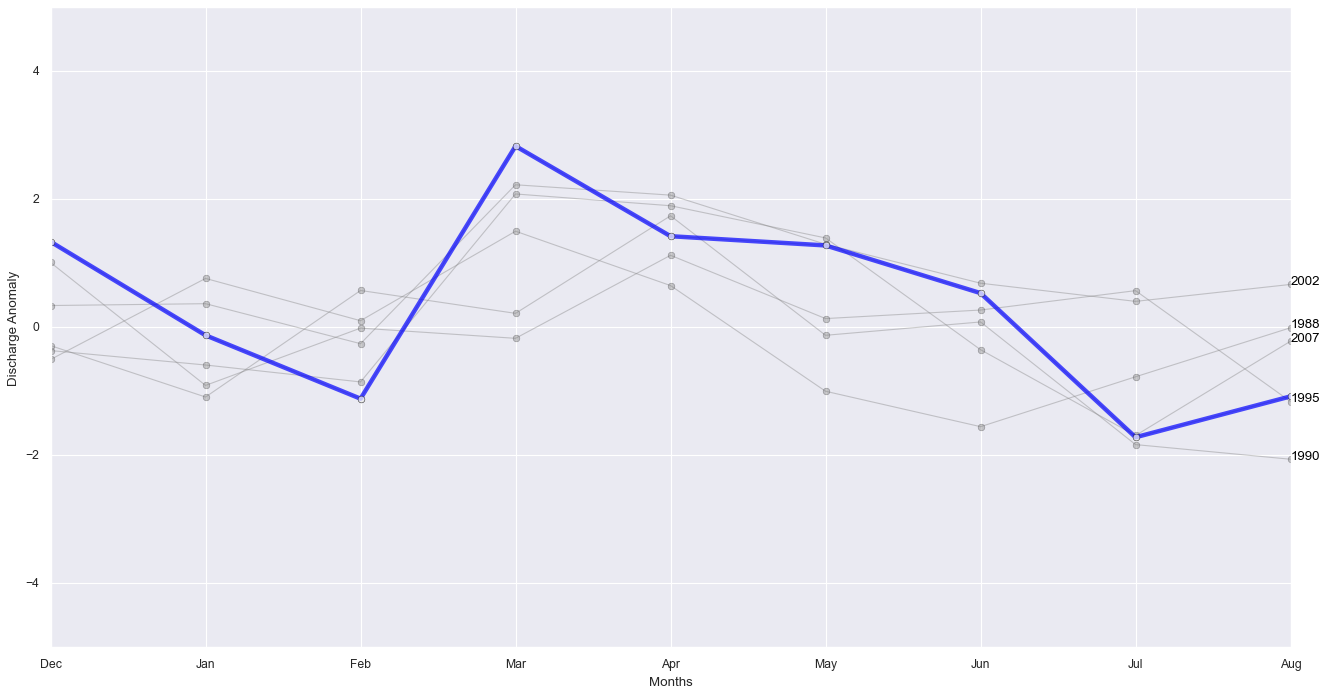

In [22]:
plt.figure(figsize=(20, 10))

# plot multiple lines
for column in ANOMALY_PLOT.drop('MONTH', axis=1):
    plt.plot(ANOMALY_PLOT['MONTH'], ANOMALY_PLOT[column], marker='o', color='grey', linewidth=1, alpha=0.4);

# Now re do the interesting curve, but biger with distinct color
plt.plot(ANOMALY_PLOT['MONTH'], ANOMALY_PLOT['REF'], marker='o', color='blue', linewidth=4, alpha=0.7,mfc='white', mec='k');

num=0
for i in ANOMALY_PLOT.values[8][1:]:
    num+=1
    name=list(ANOMALY_PLOT)[num]
    if name != 'REF':
        plt.text(8, i, name, horizontalalignment='left', size='medium', linespacing=0.4, color='black')
        
plt.ylim(-5,5)
plt.xlabel('Months');
plt.ylabel('Discharge Anomaly');

In [23]:
# Define the forecast lead-times
arr = np.array([1,2,3,4,5,6])

month_fcst = [last_month.month]
for x in arr:
    # convert to datetime the forecast lead-time
    forecast_month = add_months(last_month,x)
    # extract the month from the forecast month variable
    m = forecast_month.month
    month_fcst.append(m)
    a = [] # empty the variable a
    # For each analogue year (and its respective RMSE), we multiply the analogue year for that month and the RMSE
    for i in range(len(BEST_RMSE.RMSE)):
        y = BEST_RMSE['YEAR'].iat[i]
        a_val = DISCHARGE_MONTHLY.query('month == @m & year == @y')['anomaly'].item() * BEST_RMSE['weight'].iat[i]
        a.append(a_val)
    ANALOGUE_FCST = np.nansum(a)
    # ANALOGUE_FCST = np.sum(a)
    q2log = (ANALOGUE_FCST * DISCHARGE_MONTHLY_STATS.query('index == @m')["std"].item()) + DISCHARGE_MONTHLY_STATS.query('index == @m')["mean"].item()
    exp_log = np.exp(q2log)
    DISCHARGE_MONTHLY.loc[forecast_month] = [forecast_month.year,forecast_month.month, exp_log, q2log, ANALOGUE_FCST]

In [24]:
HTML(DISCHARGE_MONTHLY.tail(8).to_html(index=True))

,year,month,discharge,Q_to_log,anomaly
date,,,,,
2024-07-31,2024.0,7.0,20.642419,3.027348,-1.717762
2024-08-31,2024.0,8.0,30.229759,3.408827,-1.079027
2024-09-30,2024.0,9.0,69.055041,4.234904,-0.367094
2024-10-31,2024.0,10.0,63.221762,4.146649,-0.008132
2024-11-30,2024.0,11.0,38.232366,3.643682,-0.265757
2024-12-31,2024.0,12.0,22.093669,3.095291,0.067624
2025-01-31,2025.0,1.0,9.689535,2.271046,-0.309144
2025-02-28,2025.0,2.0,16.020784,2.773887,-0.194134


In [25]:
ndata = DISCHARGE_MONTHLY.iloc[(DISCHARGE_MONTHLY.index >= '2024-01-01') & (DISCHARGE_MONTHLY.index <= '2025-01-31')]

In [26]:
ndata.index = ndata.index.map(lambda t: t.replace(day=1))

In [27]:
# create empty columns in the dataframe
ndata['25th_percentile'] = np.nan
ndata['75th_percentile'] = np.nan

for i in range(len(ndata)):
    # Extract the current month 
    m = ndata.month[i]
    y = ndata.year[i]
    ndata.loc[ndata.eval('month==@m & year==@y'),'25th_percentile']  = Q_MONTHLY_STATS.query('index==@m')['q1'].item()
    ndata.loc[ndata.eval('month==@m & year==@y'),'75th_percentile']  = Q_MONTHLY_STATS.query('index==@m')['q3'].item()

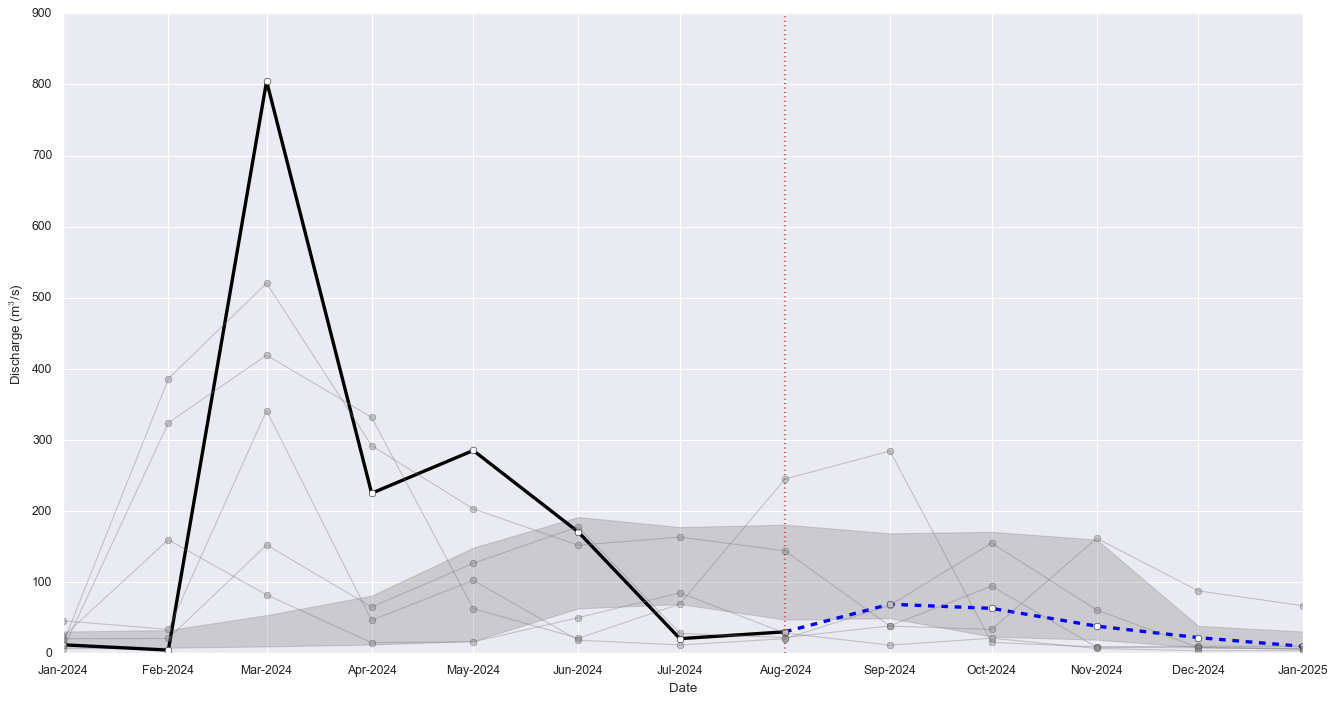

In [28]:
import matplotlib.dates as mdates

y1 = ndata.iloc[ndata.index <= last_month.replace(day=1).strftime('%Y-%m-%d')]
y2 = ndata.iloc[ndata.index >= last_month.replace(day=1).strftime('%Y-%m-%d')]
# y3 = ndata.iloc[ndata.index >= last_month.replace(day=1).strftime('%Y-%m-%d')]

fig1, ax1 = plt.subplots(figsize=(20, 10))
ax1.plot(y1.index,y1['discharge'],linestyle = '-', color = 'black',linewidth=3, marker='o', mfc='white', mec='k')
ax1.plot(y2.index,y2['discharge'],linestyle = '--', color = 'blue', linewidth=3, marker='o', mfc='white', mec='k')
ax1.set_xlabel('Date');
ax1.set_ylabel('Discharge (m$^3$/s)');
ax1.axvline(x = last_month.replace(day=1), color = 'r',label = 'now', linestyle=':', linewidth=2, mfc='white', mec='k');

ax1.fill_between(ndata.index, ndata['25th_percentile'], ndata['75th_percentile'], color='grey', alpha=0.3,label="Normal")

for y in BEST_RMSE['YEAR'].tolist():
    m = last_month.month
    query_result_indices = DISCHARGE_MONTHLY.query("month == @m & year == @y").index
    start_index = query_result_indices[0] -  pd.DateOffset(months=6)
    end_index = query_result_indices[0] +  pd.DateOffset(months=6)
    extracted_values = DISCHARGE_MONTHLY.loc[start_index:end_index]
    extracted_values.index = extracted_values.index.map(lambda t: t.replace(day=1))
    extracted_values.index = ndata.index
    ax1.plot(extracted_values.index, extracted_values['discharge'],  marker='o', color='grey', linewidth=1, alpha=0.4,label=y);


# ax1.set_ylim([0,20]);
ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=1))   #to get a tick every 1 month
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b-%Y'))   #optional formatting 
plt.xticks(rotation=0);

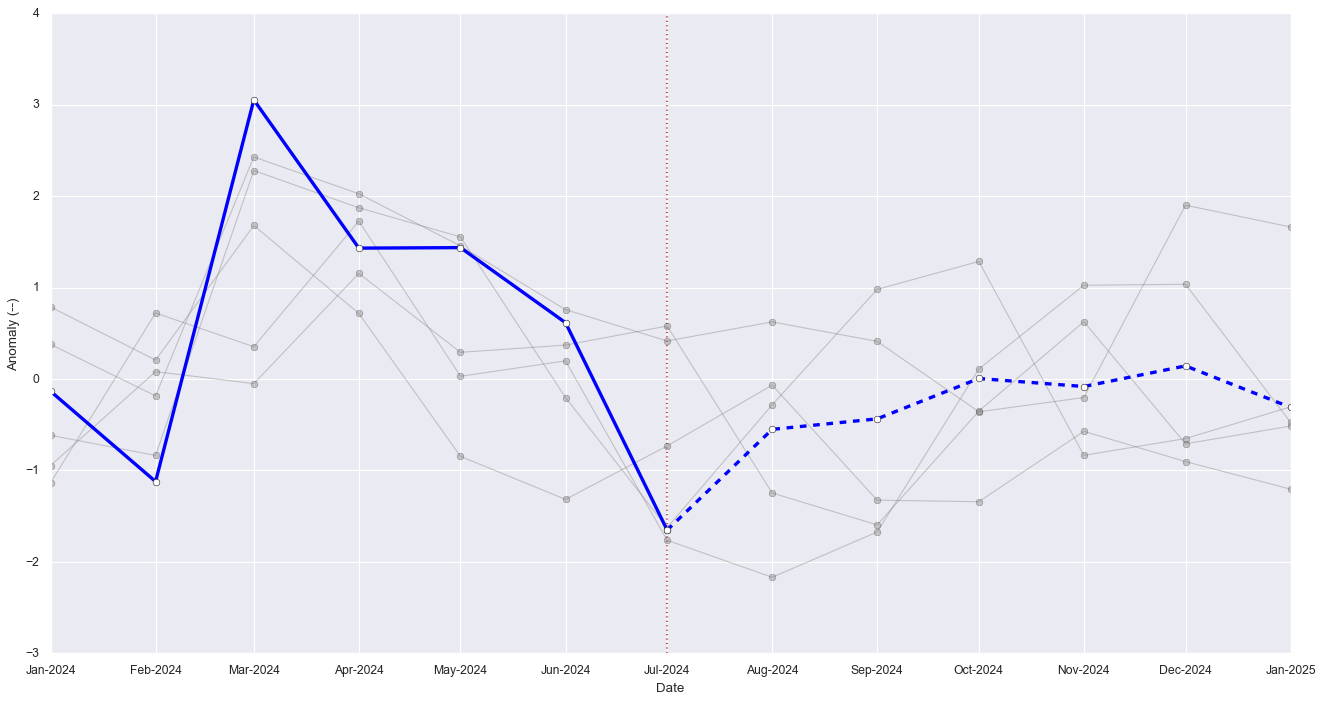

In [36]:
fig3, ax3 = plt.subplots(figsize=(20, 10))

ax3.axvline(x = last_month.replace(day=1), color = 'r',label = 'now', linestyle=':', linewidth=2, mfc='white', mec='k');
ax3.set_xlabel('Date');
ax3.set_ylabel('Anomaly (--)');

for y in BEST_RMSE['YEAR'].tolist():
    m = last_month.month
    query_result_indices = DISCHARGE_MONTHLY.query("month == @m & year == @y").index
    start_index = query_result_indices[0] -  pd.DateOffset(months=6)
    end_index = query_result_indices[0] +  pd.DateOffset(months=6)
    extracted_values = DISCHARGE_MONTHLY.loc[start_index:end_index]
    extracted_values.index = extracted_values.index.map(lambda t: t.replace(day=1))
    extracted_values.index = ndata.index
    # print(extracted_values.query('month==10')['anomaly'].item())
    ax3.plot(extracted_values.index, extracted_values['anomaly'],  marker='o', color='grey', linewidth=1, alpha=0.4,label=y);

# ax3.plot(ndata.index, ndata['anomaly'],marker='o', color='red', linewidth=4, alpha=0.7)
ax3.plot(y1.index,y1['anomaly'],linestyle = '-', color = 'blue',linewidth=3, marker='o', mfc='white', mec='k')
ax3.plot(y2.index,y2['anomaly'],linestyle = '--', color = 'blue', linewidth=3, marker='o', mfc='white', mec='k')

# ax3.set_ylim([-7,7]);
ax3.xaxis.set_major_locator(mdates.MonthLocator(interval=1))   #to get a tick every 1 month
ax3.xaxis.set_major_formatter(mdates.DateFormatter('%b-%Y'))   #optional formatting 
plt.xticks(rotation=0);

In [37]:
BEST_RMSE

,YEAR,RMSE,RMSE_inv,weight
22,2007,0.899963,1.111156,0.272376
17,2002,1.155910,0.865119,0.212065
8,1990,1.351068,0.740155,0.181433
6,1988,1.418426,0.705007,0.172817
12,1995,1.519629,0.658055,0.161308
